In [1]:
#data manipulation
import pandas as pd
import numpy as np
import sklearn

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

#saving
import pickle

In [2]:
df = pd.read_csv("/nfs/2week/38454/diabetic_data.csv")

In [3]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Ok so now we have our data loaded into our pandas dataframe. <br />
We are going to start off with some general exploratory data analysis just because it's fun. <br />
This project is a pretty standard cut-and-dry logistic regression/random forrest binary classification task so EDA isn't like /a bad idea/ but I don't think it's strictly necessary here.

In [5]:
print(df.shape)
df.info()

(101766, 50)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int

So this dataset contains 101766 rows, each with 50 columns, where column 49 (readmitted) is our target value. Interestingly, while there are many corrupted or incomplete data values in this set (as well see later) none of the entries are explicitly null. <br />
This isn't a huge issue it just means we can't use certain pandas null-checking functions

In [7]:
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


This really doesn't tell us a whole lot to be honest. Some of the info is worth noting, like time in hospital or.... thats about it. A lot of the generally numbered attributes such as weight are nominal attributes in this dataset because theyre're entered as a range instead of a single value.

In [9]:
#Let's take a look specifically at the weight column for just a second
df['weight'].head()

0    ?
1    ?
2    ?
3    ?
4    ?
Name: weight, dtype: object

As we can see, many of the values in this column, as well as a couple other columns are null ("?" specifically). <br />
Generally, we would have to do some math to figure out the distribution of the values in the... problematic columns but luckily the dataset authors have provided a link to a paper that's already done this for us. <br />
http://www.hindawi.com/journals/bmri/2014/781670/

From this paper we can see 97% of the weight values are missing: <br />
52% of the payer code values are missing <br />
53% of the medical specialty values are missing <br />
2% of the race values are missing <br />
1% of the diagnosis 3 values are missing <br />

While I think we can work around the missing race and diagnosis 3 values, the weight, payer code, and medical speciality columns are simply too incomplete to be worth while and will be dropped. I would have liked to keep weight, but I don't think medical speciality and payer code will have much of a contribution to the chances of readmission

In [12]:
df = df.drop(['weight','payer_code','medical_specialty'],axis=1)
print("New dataframe Shape",df.shape)

New dataframe Shape (101766, 47)


We're also going to fix the target values. <br />
Right now the readmitted column contains 3 categories: No, >30, and <30 <br />
In this project we only care about if the patient was admitted within 30 days of previous admission. So, we're going to replace the values in the target column to binary classifiers - 1 for readmitted with 30 days and 0 for not readmitted within 30 days.

In [13]:
df['readmitted'] = df['readmitted'].replace("<30",1)
df['readmitted'] = df['readmitted'].replace([">30","NO"],0)

print("Our new dataframe")
df.head(10)

Our new dataframe


,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,...,No,No,No,No,No,No,No,No,No,0
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,0
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,0
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,0
5,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,31,...,No,Steady,No,No,No,No,No,No,Yes,0
6,55842,84259809,Caucasian,Male,[60-70),3,1,2,4,70,...,No,Steady,No,No,No,No,No,Ch,Yes,0
7,63768,114882984,Caucasian,Male,[70-80),1,1,7,5,73,...,No,No,No,No,No,No,No,No,Yes,0
8,12522,48330783,Caucasian,Female,[80-90),2,1,4,13,68,...,No,Steady,No,No,No,No,No,Ch,Yes,0
9,15738,63555939,Caucasian,Female,[90-100),3,3,4,12,33,...,No,Steady,No,No,No,No,No,Ch,Yes,0


Let's look at the distribution of our target variable to make sure out dataset is balanced

0    90409
1    11357
Name: readmitted, dtype: int64


array([[<AxesSubplot:title={'center':'readmitted'}>]], dtype=object)

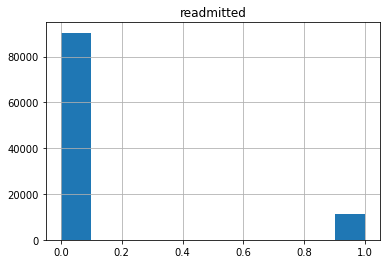

In [14]:
print(df['readmitted'].value_counts())

df.hist('readmitted')

Roughly 10% of our target variables are 1 (readmitted within 30 days) <br />
That's an ehhhhh distribution and may require some dataset balancing techniques. For now we'll attempt just some simple random over-sampling.

We're going to use seaborns paurplot to display all variables against each other in a scatter plot. This can help us spot interesting relationships without having to go through ever value manually. <br />
Interestingly, after running this block the file becomes too large to save hehe. We'll save it to a png on the first pass and just load that png on all subsequent passes.

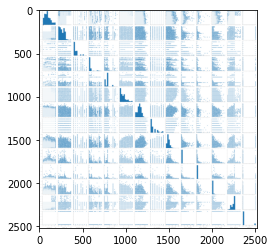

In [17]:
#pairplot = sns.pairplot(df)
#plt.savefig("pairplot.png")

#I commented out the code to actually create and save the pairplot because
#it takes a long time to run, I've already done it once and just saved
#the image so I can display it that way :)
import matplotlib.image as mpimg

img = mpimg.imread('pairplot.png')
imgplot = plt.imshow(img)
plt.show()

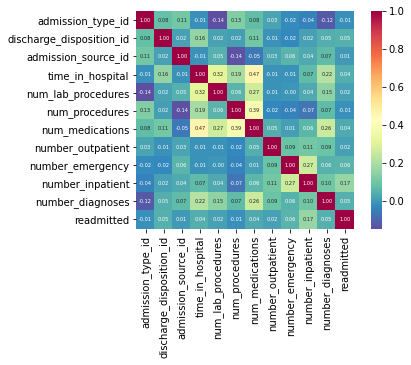

In [72]:
corrmat = df.corr()
hm = sns.heatmap(corrmat, 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 5}, 
                 cmap="Spectral_r")
plt.savefig("heatmap.png")

Above we can see how correlated certain pairs of variables are.
The strongest correlation appears to be between number of lab procedures and number of medications.

Alright, just because I'm essentially certain they aren't useful I'm going to go ahead and drop encounter id and patient number. They'll probably throw off certain models anyways as they're pretty large numbers

In [17]:
df = df.drop(['encounter_id','patient_nbr'], axis=1)

I'm going to attempt to use sklearn's simple imputer to replace missing values with a constant string. <br />
In this case we'll set the constant string to "missing", I had thought's about using a k-nearest neighbours imputer which still may work but it was too much work to set up and I don't think it'll matter too much in this instance. <br />
First I'll have to do some prep work and replace the "?"s with None as setup. <br />
Then we'll replace missing data and encode everything to numeric data for our classifier. <br />

In [18]:
df = df.replace("?",None)

In [19]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

#Find the categorical features we'll have to encode to numeric features
features_to_encode = df.columns[df.dtypes==object].tolist()
print("Number of categorical features: ",len(features_to_encode))
features_to_encode

Number of categorical features:  33


['race',
 'gender',
 'age',
 'diag_1',
 'diag_2',
 'diag_3',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed']

In [20]:
from sklearn.impute import SimpleImputer
cat_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                    ('encoder', OneHotEncoder(handle_unknown="ignore"))
                                    ])
                                 

col_trans = make_column_transformer(
        (cat_transformer, features_to_encode), remainder = "passthrough")


We now have our pipeline ready to pass into our model. <br />
We just have to prepare the data now.

In [21]:
#Oversample the dataset
target_1 = df[df['readmitted'] == 1]
target_0 = df[df['readmitted'] == 0]

class_0,class_1 = df.readmitted.value_counts()
print("Target = 0: ",class_0)
print("Target = 1: ",class_1)

#Oversample target data so readmitted=1 makes up a third of the samples
df_sample = target_1.sample(class_0//2, replace=True) 
oversampled_df = pd.concat([target_0,df_sample], axis = 0)

print("New Distribution of target values: ")
print(oversampled_df.readmitted.value_counts())
oversampled_df.head()

Target = 0:  90409
Target = 1:  11357
New Distribution of target values: 
0    90409
1    45204
Name: readmitted, dtype: int64


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),6,25,1,1,41,0,1,...,No,No,No,No,No,No,No,No,No,0
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,...,No,Up,No,No,No,No,No,Ch,Yes,0
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,...,No,No,No,No,No,No,No,No,Yes,0
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,...,No,Steady,No,No,No,No,No,Ch,Yes,0


In [22]:
#Split into train and test set
from sklearn.model_selection import train_test_split
train, test = train_test_split(oversampled_df, test_size=0.2)

#Split into features/inputs (x) and target (y)
train_x = train[train.columns[0:-1]]
test_x = test[test.columns[0:-1]]

train_y = train['readmitted']
test_y = test['readmitted']

In [25]:
train_x.head(3)

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
43504,Caucasian,Female,[50-60),1,1,7,1,25,0,10,...,No,No,Steady,No,No,No,No,No,Ch,Yes
31470,Caucasian,Female,[70-80),6,1,17,5,27,2,11,...,No,No,No,No,No,No,No,No,No,No
18873,AfricanAmerican,Male,[50-60),1,6,7,3,32,2,10,...,No,No,No,No,No,No,No,No,No,Yes


In [26]:
train_y.head(10)

43504    0
31470    0
18873    0
70468    0
63542    0
93265    0
12794    0
3994     1
92406    0
12206    1
Name: readmitted, dtype: int64

In [24]:
#Random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

rf_classifier = RandomForestClassifier(n_estimators=10, random_state=43)
rfc = make_pipeline(col_trans, rf_classifier)

In [28]:
rfc.fit(train_x, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['race', 'gender', 'age',
                                                   'diag_1', 'diag_2', 'diag_3',
                                                   'max_glu_serum', 'A1Cresult',
                                                   'metformin', 'repaglinide',
                                                  

In [29]:
#Save model
pickle.dump(rfc, open("randomforest.sav","wb"))

So we've trained our random forrest. <br />
First thing we'll do is check the Receiver Operating Characteristic (ROC) curve. A ROC curve is just a plot that shows how well your binary classifier operates as its discrimination threshold is varied. The Y-Axis is is the True Positive Rate and the X-Axis is the False Positive Rate. Ideally you want youre graph to look like a completely straight line going straight up the X-Axis, with a sharp 90 degree turn at the top and continuing in a straight line to the right at Y=1.0

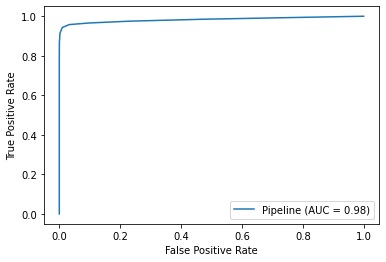

In [31]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(rfc, test_x, test_y)
plt.show()

This ROC curve is already pretty good, though lets preform some hyper parameter tunning and see if we can get it just a little bit better before fully evaluating our model

In [33]:
#Getting the names of parameters we can set for tunning
rfc.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'randomforestclassifier', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__pipeline', 'columntransformer__pipeline__memory', 'columntransformer__pipeline__steps', 'columntransformer__pipeline__verbose', 'columntransformer__pipeline__imputer', 'columntransformer__pipeline__encoder', 'columntransformer__pipeline__imputer__add_indicator', 'columntransformer__pipeline__imputer__copy', 'columntransformer__pipeline__imputer__fill_value', 'columntransformer__pipeline__imputer__missing_values', 'columntransformer__pipeline__imputer__strategy', 'columntransformer__pipeline__imputer__verbose', 'columntransformer__pipeline__encoder__categories', 'columntransformer__pipeline__encoder__drop', 'columntransformer__pipeline__encoder__dtype', 'columntransformer__pipe

In [28]:
from sklearn.model_selection import GridSearchCV

#Set the parameters we want to tune and the values we wants to test
param_grid={
    'randomforestclassifier__n_estimators': [5,10,25],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],
    'randomforestclassifier__criterion': ['gini', 'entropy']
}
rfc = pickle.load(open("randomforest.sav", 'rb')) #Load model so we can restart kernel w/ out having to retrain
clf_hyper = GridSearchCV(rfc, param_grid, cv=5, scoring='f1', verbose=2)

#Start searching for the best combo
clf_hyper.fit(train_x, train_y)
pickle.dump(clf_hyper, open("clf_hyper.sav","wb")) #Save

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=5, total=   8.6s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s remaining:    0.0s


[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=5, total=   7.2s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=5 
[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=5, total=   7.9s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=5 
[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=5, total=   7.9s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=5 
[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=5, total=   7.1s
[CV] randomforestclassifier__criterion=gini,

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 26.4min finished


Now that we've found the best parameters for our random forest lets take a look at what they are

In [29]:
clf_hyper.best_params_

{'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_features': 'log2',
 'randomforestclassifier__n_estimators': 25}

In [30]:
clf_hyper.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['race', 'gender', 'age',
                                                   'diag_1', 'diag_2', 'diag_3',
                                                   'max_glu_serum', 'A1Cresult',
                                                   'metformin', 'repaglinide',
                                                  

In [25]:
#Ok, let's create a random forest with these parameters and see if we can do any better
rf_classifier_hyper = RandomForestClassifier(n_estimators=25, random_state=43, criterion='entropy',max_features='log2')
rfc_hyper = make_pipeline(col_trans, rf_classifier_hyper)

In [26]:
rfc_hyper.fit(train_x, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['race', 'gender', 'age',
                                                   'diag_1', 'diag_2', 'diag_3',
                                                   'max_glu_serum', 'A1Cresult',
                                                   'metformin', 'repaglinide',
                                                  

In [46]:
#Lets quickly save our model just in case
pickle.dump(rfc_hyper, open("randomforest_hyper.sav","wb"))

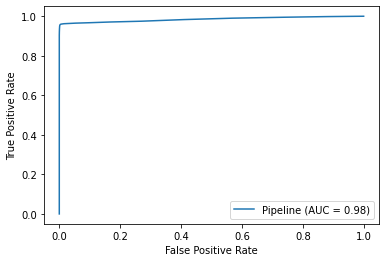

In [28]:
plot_roc_curve(rfc_hyper, test_x, test_y)
plt.show()

In [46]:
test_predict_Y = rfc.predict(test_x)

In [47]:
#Calculate confusion matrix items
#Standard random forest
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y, test_predict_Y, labels=[0, 1])

FN = cm.sum(axis=0) - np.diag(cm)  
FP = cm.sum(axis=1) - np.diag(cm)
TN = np.diag(cm)
TP = cm.sum() - (FP + FN + TP)

print(cm)
print("False Positive Rates: ",FP)
print("False Negative Rates: ",FN)
print("True Positive Rates: ", TP)
print("True Negative Rates: ",TN)

[[17859    39]
 [  536  8689]]
False Positive Rates:  [ 39 536]
False Negative Rates:  [536  39]
True Positive Rates:  [17700  8718]
True Negative Rates:  [17859  8689]


In [48]:
test_predict_Y = rfc_hyper.predict(test_x)

In [49]:
#Calculate confusion matrix items
#Random forest with hyper-parameter tunning
cm = confusion_matrix(test_y, test_predict_Y, labels=[0, 1])

FN = cm.sum(axis=0) - np.diag(cm)  
FP = cm.sum(axis=1) - np.diag(cm)
TN = np.diag(cm)
TP = cm.sum() - (FP + FN + TP)

print(cm)
print("False Positive Rates: ",FP)
print("False Negative Rates: ",FN)
print("True Positive Rates: ", TP)
print("True Negative Rates: ",TN)

[[17830    68]
 [  377  8848]]
False Positive Rates:  [ 68 377]
False Negative Rates:  [377  68]
True Positive Rates:  [ 8978 17960]
True Negative Rates:  [17830  8848]


As a note the confusion matrix is displayed as: <br />
TN | FP <br />
FN | TP <br />
<br />
Just eyeballing the ROC curves, the random forest w/ hyper-parameter (HP) tunning appears better. Though, looking at the confusion matrix we can see the random forest w/ hyper-parameter (HP) tunning has a slightly higher (0.3% difference) false positive rate. False positive in this context meaning a person was predicted to be readmitted within 30 days and was not. Though our tunned model has a better (lower) false negative rate by almost a whole percent. The means the model is less likely to predict someone won't readmitted when they actually will be. <br />
<br />
In a sense, our second model is more biased towards predicting people will be readmitted than our untunned random forest. This is an ok trade off for me, but let's run some more metrics just to fully evaluate our models. 

In [50]:
#Precision
from sklearn.metrics import precision_score

test_predict_Y = rfc.predict(test_x)
print("Precision random forest: ",precision_score(test_y, test_predict_Y, average='binary'))

test_predict_Y = rfc_hyper.predict(test_x)
print("Precision random forest w/ HP Tunning: ",precision_score(test_y, test_predict_Y, average='binary'))

Precision random forest:  0.995531622364803
Precision random forest w/ HP Tunning:  0.9923732615522656


Precision is the number of true positives over true positives+false positives. <br />
It's the percentage of positive predictions that are actually positive. Again, we can see our tunned model is slightly more over-biased towards positive predictions.

In [51]:
#Recall
#TP/(TP+FN) 
#The percentage of positive predictions out of the total number of positive instances 
from sklearn.metrics import recall_score

test_predict_Y = rfc.predict(test_x)
print("Recall random forest: ",recall_score(test_y, test_predict_Y, average='binary'))

test_predict_Y = rfc_hyper.predict(test_x)
print("Recall random forest w/ HP Tunning: ",recall_score(test_y, test_predict_Y, average='binary'))

Recall random forest:  0.9418970189701897
Recall random forest w/ HP Tunning:  0.9591327913279133


While our tunned model may have slightly lower precision, it has much higher recall, meaning it catches more actually positive results.

In [52]:
#F1 Score
#Harmonic mean of precision and recall
from sklearn.metrics import f1_score

test_predict_Y = rfc.predict(test_x)
print("F1 random forest: ",f1_score(test_y, test_predict_Y, average='binary'))

test_predict_Y = rfc_hyper.predict(test_x)
print("F1 random forest w/ HP Tunning: ",f1_score(test_y, test_predict_Y, average='binary'))

F1 random forest:  0.9679719266974879
F1 random forest w/ HP Tunning:  0.975469929992834


In [53]:
#R2 Score
#The total variance explained by the model over the total variance
#A high score means a high correlation which is what we want
from sklearn.metrics import r2_score

test_predict_Y = rfc.predict(test_x)
print("R2 random forest: ",r2_score(test_y, test_predict_Y))

test_predict_Y = rfc_hyper.predict(test_x)
print("R2 random forest w/ HP Tunning: ",r2_score(test_y, test_predict_Y))

R2 random forest:  0.9055428821133669
R2 random forest w/ HP Tunning:  0.926898404418171


Our tunned model is also better at explaining the variance which is good.

In [54]:
#Accuracy score
#Just how accurate the model is, pretty self explanetory 
from sklearn.metrics import accuracy_score

test_predict_Y = rfc.predict(test_x)
print("Accuracy random forest: ",accuracy_score(test_y, test_predict_Y))

test_predict_Y = rfc_hyper.predict(test_x)
print("Accuracy random forest w/ HP Tunning: ",accuracy_score(test_y, test_predict_Y))

Accuracy random forest:  0.9788002802049921
Accuracy random forest w/ HP Tunning:  0.9835932603325591


In [55]:
#MAE Score
#Mean absolute error
from sklearn.metrics import mean_absolute_error

test_predict_Y = rfc.predict(test_x)
print("MAE random forest: ",mean_absolute_error(test_y, test_predict_Y))

test_predict_Y = rfc_hyper.predict(test_x)
print("MAE random forest w/ HP Tunning: ",mean_absolute_error(test_y, test_predict_Y))

MAE random forest:  0.021199719795007926
MAE random forest w/ HP Tunning:  0.01640673966744092


In [57]:
#Mean Squared Error (MSE)
from sklearn.metrics import mean_squared_error

test_predict_Y = rfc.predict(test_x)
print("MSE random forest: ",mean_squared_error(test_y, test_predict_Y))

test_predict_Y = rfc_hyper.predict(test_x)
print("MSE random forest w/ HP Tunning: ",mean_squared_error(test_y, test_predict_Y))

MSE random forest:  0.021199719795007926
MSE random forest w/ HP Tunning:  0.01640673966744092


Lets try out logistic regression to see if it's any better

In [28]:
from sklearn.linear_model import LogisticRegression

logReg = LogisticRegression(penalty='l2',max_iter=5000)
logReg_pipe = make_pipeline(col_trans, logReg)

In [29]:
#Train our model
logReg_pipe.fit(train_x,train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['race', 'gender', 'age',
                                                   'diag_1', 'diag_2', 'diag_3',
                                                   'max_glu_serum', 'A1Cresult',
                                                   'metformin', 'repaglinide',
                                                  

In [33]:
#Save model
import pickle 

pickle.dump(logReg_pipe, open("logistic_regression.sav","wb"))

Sometimes depending on the start state and random list of training samples we'll get a warning telling us the model failed to converge with 'only' 5,000 iterations. Luckily, this time it doesn't appear to have happened. My initial guess is that this will be worse than the random forest. But let's take a look.

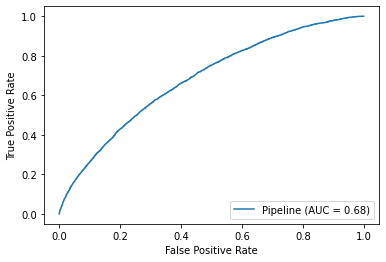

In [30]:
plot_roc_curve(logReg_pipe, test_x, test_y)
plt.show()

In [32]:
#Calculate confusion matrix items
#Logistic Regression
from sklearn.metrics import confusion_matrix

test_predict_Y = logReg_pipe.predict(test_x)
cm = confusion_matrix(test_y, test_predict_Y)

FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

print(cm)
print("False Positive Rates: ",FP)
print("False Negative Rates: ",FN)
print("True Positive Rates: ", TP)
print("True Negative Rates: ",TN)

[[16589  1420]
 [ 7085  2029]]
False Positive Rates:  [7085 1420]
False Negative Rates:  [1420 7085]
True Positive Rates:  [16589  2029]
True Negative Rates:  [ 2029 16589]


Just from initial assessment, we can already tell the performance of this model is worse than the random forest. The TP and TN rates are lower by several thousand in both instances.

For the purposes of this project I'm happy with this results. If this was a real project to develop a model to be actually used in the real world I would spend longer doing EDA and testing more models/parameters. Though, while I understand to some degree I'm supposed to treat it like it is, it isn't. This is closer to a proof of concept to display how I'd generally tackle this kind of problem more than a deep dive into this specific instance. 